## Analysis of _Around the World in 80 days_
### Author: __Sam Lyddon__
***

This analysis uses entity recognition to extract the locations travelled to within the book _Around the World in 80 days_, and to compare them against the more general route locations obtained through manual extraction.

In [1]:
import sys
sys.path.append("..")

In [2]:
from pathlib import Path
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point

from src import RequestHandler, Document

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext watermark
%watermark -d -t -u
%watermark -iv -v

last updated: 2020-03-04 16:11:38
numpy 1.18.1
CPython 3.7.6
IPython 7.12.0


In [5]:
%load_ext lab_black

#### Pull in the text
***
Scrape the book text from the Project Gutenberg site and save locally. If this has already been done, just load in the text.

In [6]:
rq = RequestHandler()

# scrape the text from a web source
# save to local file
data_path = Path("./../data/pg103.txt")
book_path = "http://www.gutenberg.org/cache/epub/103/pg103.txt"
if not data_path.is_file():
    text = rq.scrape_text(book_path)
    data_path.write_text(text)
else:
    text = data_path.read_text()

#### Read document
***

Parse the document into chapters and paragraphs. Extract metadata.

In [7]:
%%time
doc = Document(text)
print(
    f"{doc.title} - {doc.author} - {doc.release_date} - {doc.last_updated} - {doc.language}\n"
)

Around the World in 80 Days - Jules Verne - May 15, 2008 [EBook #103] - May 5, 2012 - English

CPU times: user 6.28 s, sys: 1.16 s, total: 7.44 s
Wall time: 7.25 s


In [8]:
print(f"{len(doc.chapters)} chapters, {len(doc.paragraphs)} paragraphs")

37 chapters, 1605 paragraphs


In [9]:
top_n = 10
print(
    f"{top_n} most mentioned characters: {[name for name, count in sorted(Counter([person for p in doc.paragraphs for person in p.people]).items(), key = lambda x: x[1], reverse=True)][:top_n]}"
)

10 most mentioned characters: ['Passepartout', 'Mr. Fogg', 'Fix', 'Phileas Fogg', 'Aouda', 'Francis', 'Fogg', 'Rangoon', 'John Bunsby', 'Proctor']


#### Extract locations
***
1. Perform entity recognition on paragraphs to extract locations.
2. Send location to OpenStreetMap to get coordinates.
3. Filter location according to its type and class. Remove all locations where the given type-class does not appear sufficiently often.
4. Include whether the protagonist "Fogg" has been mentioned in the paragraph. 


In [10]:
locations = doc.get_locations()

### Plot route
***

Manually set some points indicative of the route taken as per the book.

In [25]:
lat = [
    51.5074,
    29.9668,
    12.6057,
    13.4269,
    19.0760,
    22.5726,
    22.3193,
    35.4437,
    37.7749,
    40.7128,
    51.5074,
]
lon = [
    0.1278,
    32.5498,
    43.3678,
    50.1756,
    72.8777,
    88.3639,
    114.1694,
    139.6380,
    -122.4194,
    -74.0060,
    0.1278,
]

Markers are scaled according to the number of occurances of the location.

Colour according to whether Fogg has been mentioned in the paragraph.

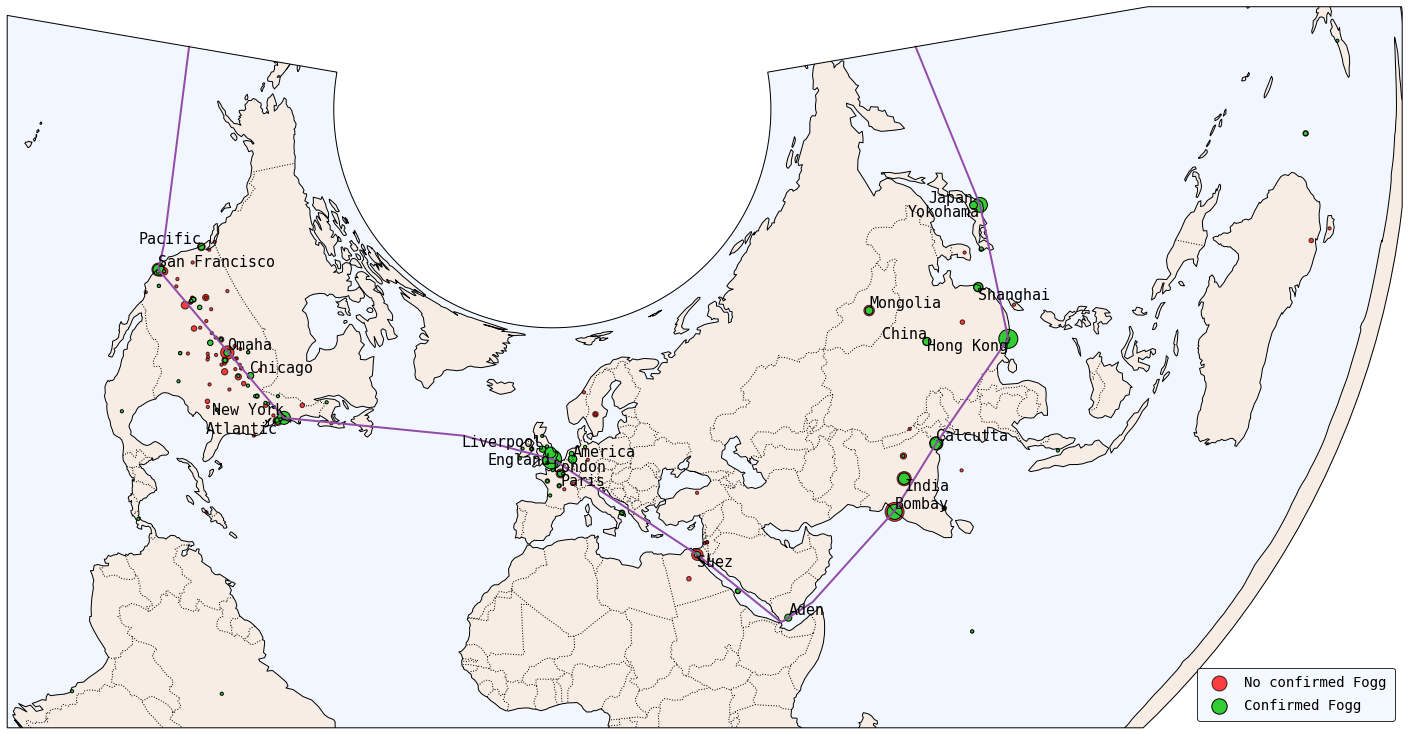

In [26]:
fig = plt.figure(figsize=(25, 15))

proj = ccrs.AlbersEqualArea()
transform = ccrs.Geodetic()

ax = plt.axes(projection=proj)
# world map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, color="#f7ede4")
ax.add_feature(cfeature.OCEAN, color="#f2f7ff")

# manually retrieved route
ax.plot(lon, lat, color="#924da8", linewidth=2, transform=transform)

# scatter where fogg has not appeared
ax.scatter(
    [loc["lon"] for loc in locations if not loc["has_fogg"]],
    [loc["lat"] for loc in locations if not loc["has_fogg"]],
    s=[loc["count"] * 10 for loc in locations if not loc["has_fogg"]],
    marker="o",
    edgecolors="black",
    color="red",
    alpha=0.75,
    transform=transform,
    label="No confirmed Fogg",
)
# scatter where fogg has appeared
ax.scatter(
    [loc["lon"] for loc in locations if loc["has_fogg"]],
    [loc["lat"] for loc in locations if loc["has_fogg"]],
    s=[loc["count"] * 10 for loc in locations if loc["has_fogg"]],
    marker="o",
    edgecolors="black",
    color="limegreen",
    transform=transform,
    label="Confirmed Fogg",
)
# label locations where fogg has appeared in over n paragraphs
for loc in locations:
    if loc["has_fogg"] and loc["count"] > 3:
        horizontalalignment = ["left", "right"][np.random.randint(2)]
        verticalalignment = ["top", "bottom"][np.random.randint(2)]
        ax.text(
            loc["lon"],
            loc["lat"],
            loc["location"],
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            fontdict={"family": "monospace", "fontsize": 15, "color": "black"},
            transform=transform,
        )

ax.legend(
    markerscale=1.1,
    facecolor="#f2f7ff",
    edgecolor="black",
    borderpad=0.6,
    labelspacing=0.6,
    fancybox=True,
    prop={"family": "monospace", "size": 14},
    loc="best",
)

plt.show()

Zoom in on the continental united states. Colour each state according to whether there have been more than 2 "confirmed" sightings of Fogg in-state.

In [13]:
lon_limit = -120, -62
lat_limit = 20, 50

limit_loc = [
    l
    for l in locations
    if (
        lon_limit[0] < l["lon"]
        and l["lon"] < lon_limit[1]
        and lat_limit[0] < l["lat"]
        and l["lat"] < lat_limit[1]
    )
]

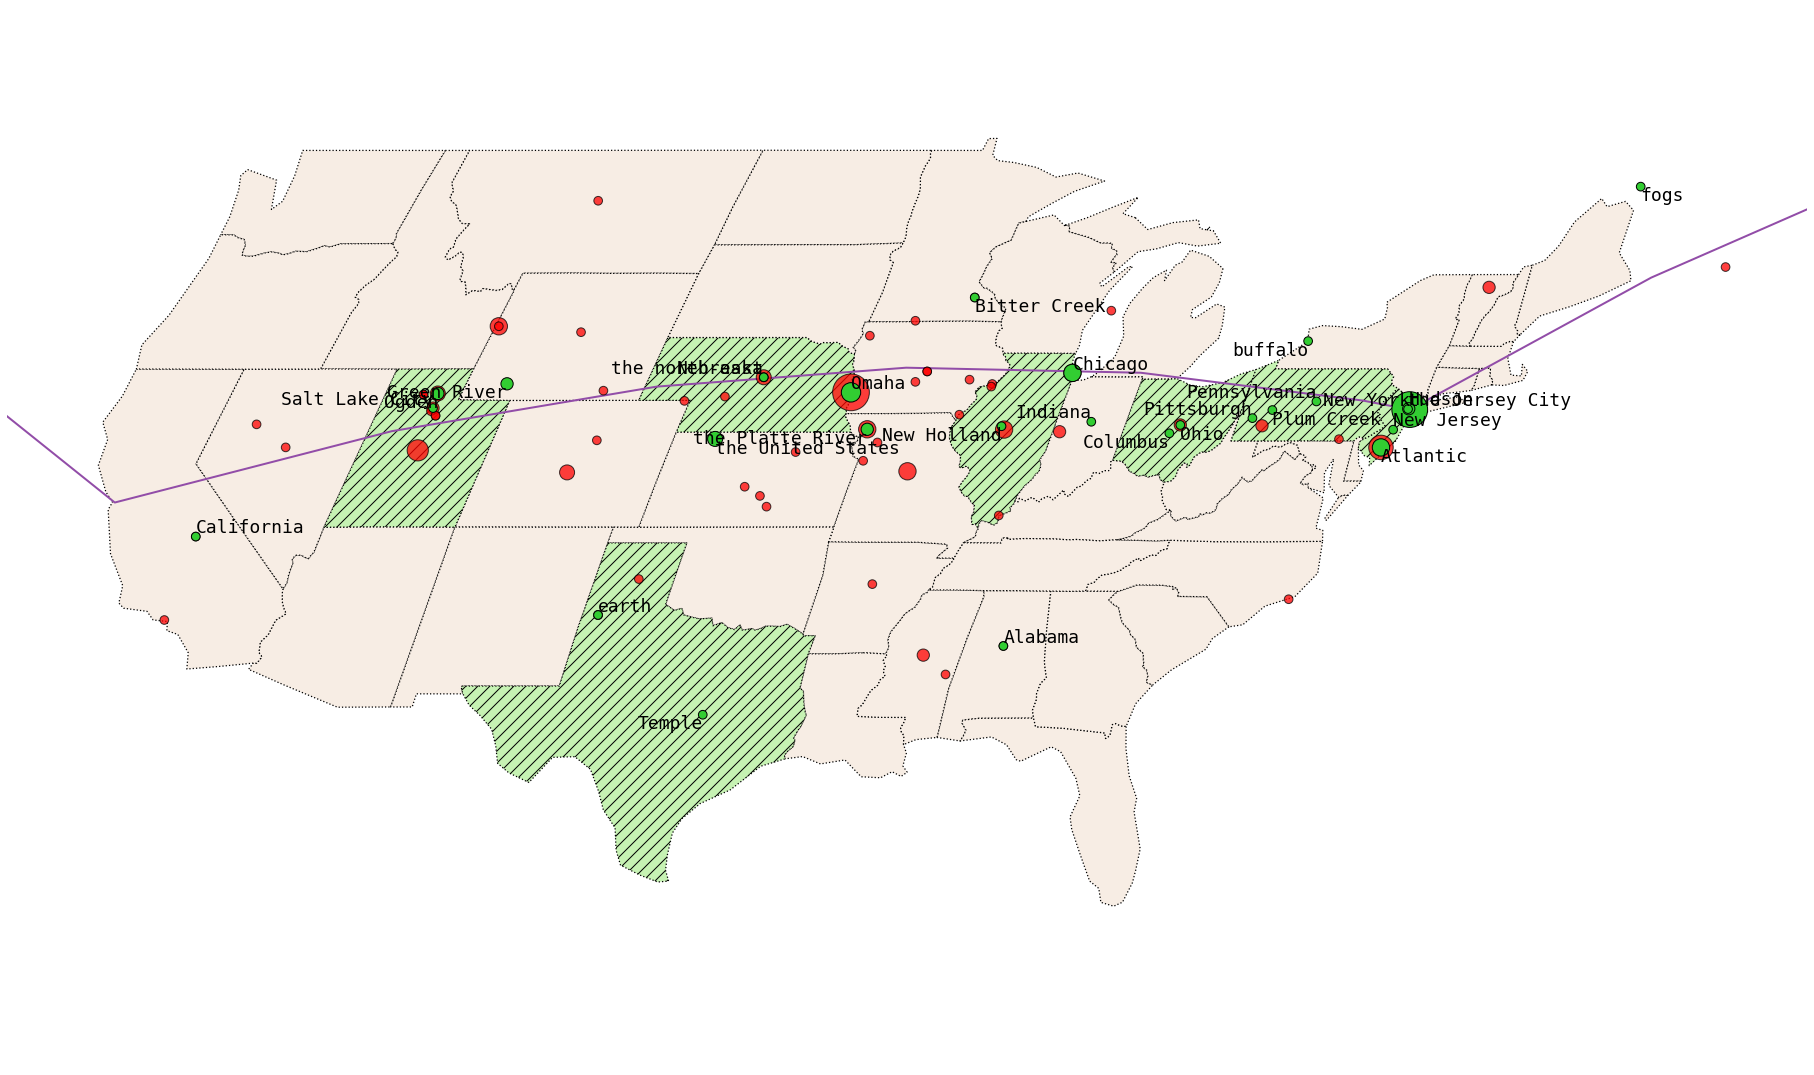

In [14]:
fig = plt.figure(figsize=(25, 15))

projection = ccrs.Robinson()
transform = ccrs.Geodetic()

ax = plt.axes([0, 0, 1, 1], projection=projection)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
ax.set_extent([lon_limit[0], lon_limit[1], lat_limit[0], lat_limit[1]], transform)


def loc_in_state(state, loc):
    return state.geometry.contains(Point([loc["lon"], loc["lat"]])) and loc["has_fogg"]


# plot the continental united states
shapename = "admin_1_states_provinces_lakes_shp"
shpfilename = shpreader.natural_earth(
    resolution="110m", category="cultural", name=shapename
)
reader = shpreader.Reader(shpfilename)
states = reader.records()
for state in states:
    if sum(loc_in_state(state, loc) for loc in limit_loc) > 1:
        facecolor = "#c6f2b3"
        hatch = "//"
    else:
        facecolor = "#f7ede4"
        hatch = ""

    ax.add_geometries(
        state.geometry,
        ccrs.PlateCarree(),
        edgecolor="black",
        linewidth=1.25,
        linestyle=":",
        color=facecolor,
        hatch=hatch,
        zorder=1,
    )

# manually retrieved route
ax.plot(lon, lat, color="#924da8", linewidth=2, transform=transform)

# scatter where fogg has not appeared
ax.scatter(
    [loc["lon"] for loc in limit_loc if not loc["has_fogg"]],
    [loc["lat"] for loc in limit_loc if not loc["has_fogg"]],
    s=[loc["count"] * 75 for loc in limit_loc if not loc["has_fogg"]],
    marker="o",
    edgecolors="black",
    color="red",
    alpha=0.75,
    transform=transform,
    label="No confirmed Fogg",
    zorder=1000,
)
# scatter where fogg has appeared
ax.scatter(
    [loc["lon"] for loc in limit_loc if loc["has_fogg"]],
    [loc["lat"] for loc in limit_loc if loc["has_fogg"]],
    s=[loc["count"] * 75 for loc in limit_loc if loc["has_fogg"]],
    marker="o",
    edgecolors="black",
    color="limegreen",
    transform=transform,
    label="Confirmed Fogg",
    zorder=1001,
)
# label locations where fogg has appeared in over n paragraphs
for loc in limit_loc:
    if loc["has_fogg"] and loc["count"] > 0:
        horizontalalignment = ["left", "right"][np.random.randint(2)]
        verticalalignment = ["top", "bottom"][np.random.randint(2)]
        ax.text(
            loc["lon"],
            loc["lat"],
            loc["location"],
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            fontdict={"family": "monospace", "fontsize": 18, "color": "black"},
            transform=transform,
            zorder=1002,
        )
plt.show()

### TODO
***
Improve use of contextual information e.g. surrounding paragraphs to:

* attribute places to people
* attribute times to places

***